## 1.

*Recogiendo los datos de coronavirus de la página https://ourworldindata.org/coronavirus-source-data* 

A partir de la letra de tu DNI, elige al país que empieza por dicha letra que más fallecidos tenga. Si el país elegido no está entre el top 20 de fallecidos, elige como país España.

En este caso, utilizaremos las columnas:

- Nuevos casos
- Nuevos fallecidos
- Población
- Fallecidos totales
- Casos totales

La fecha debe estar en el índice.

1. Representa todas las columnas en un gráfica con diferentes magnitudes en el eje y para su correcta visualización.

2. Elimina la columna "Población".

3. Entrena los algoritmos de regresión que hemos visto hasta ahora para predecir dos columnas por separado: Nuevos casos y Nuevos fallecidos. Este modelo ha de entrenarse siguiendo el esquema recomendado de validación cruzada y almacenando los errores de entrenamiento y validación en cada iteración del entrenamiento. ¿Qué error se comete? ¿crees que los algoritmos de ML vistos hasta ahora son buenos para realizar un forecast de una serie temporal viendo los resultados?

4. Representa la evolución de los errores de validación y entrenamiento en una gráfica. ¿Ha habido sobreaprendizaje?. Utiliza n_iteraciones = 23 y batches = 7 para este ejercicio y solo para la columna "nuevos casos".

In [74]:
import pandas as pd 
import numpy as np 
import json
import requests
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from sklearn import model_selection
from sklearn.ensemble import RandomForestRegressor

In [2]:
def jsonlink_df(url_json):
    r = requests.get(url=url_json)
    json_readed = json.loads(r.text)
    df = pd.DataFrame(json_readed)
    return df

In [3]:
covid = jsonlink_df('https://covid.ourworldindata.org/data/owid-covid-data.json').T
covid

,continent,location,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,cardiovasc_death_rate,diabetes_prevalence,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,data,extreme_poverty,female_smokers,male_smokers
AFG,Asia,Afghanistan,3.89283e+07,54.422,18.6,2.581,1.337,1803.99,597.029,9.59,37.746,0.5,64.83,0.511,"[{'date': '2020-02-24', 'total_cases': 1.0, 'n...",NaN,NaN,NaN
ALB,Europe,Albania,2.8778e+06,104.871,38,13.188,8.643,11803.4,304.195,10.08,NaN,2.89,78.57,0.795,"[{'date': '2020-02-25', 'new_tests': 8.0, 'tot...",1.1,7.1,51.2
DZA,Africa,Algeria,4.3851e+07,17.348,29.1,6.211,3.857,13913.8,278.364,6.73,83.741,1.9,76.88,0.748,"[{'date': '2020-02-25', 'total_cases': 1.0, 'n...",0.5,0.7,30.4
AND,Europe,Andorra,77265,163.755,NaN,NaN,NaN,NaN,109.135,7.97,NaN,NaN,83.73,0.868,"[{'date': '2020-03-02', 'total_cases': 1.0, 'n...",NaN,29,37.8
AGO,Africa,Angola,3.28663e+07,23.89,16.8,2.405,1.362,5819.49,276.045,3.94,26.664,NaN,61.15,0.581,"[{'date': '2020-03-20', 'total_cases': 1.0, 'n...",NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VNM,Asia,Vietnam,9.73386e+07,308.127,32.6,7.15,4.718,6171.88,245.465,6,85.847,2.6,75.4,0.704,"[{'date': '2020-01-23', 'total_cases': 2.0, 'n...",2,1,45.9
OWID_WRL,NaN,World,7.7948e+09,58.045,30.9,8.696,5.355,15469.2,233.07,8.51,60.13,2.705,72.58,0.737,"[{'date': '2020-01-22', 'total_cases': 557.0, ...",10,6.434,34.635
YEM,Asia,Yemen,2.9826e+07,53.508,20.3,2.922,1.583,1479.15,495.003,5.35,49.542,0.7,66.12,0.47,"[{'date': '2020-04-10', 'total_cases': 1.0, 'n...",18.8,7.6,29.2
ZMB,Africa,Zambia,1.8384e+07,22.995,17.7,2.48,1.542,3689.25,234.499,3.94,13.938,2,63.89,0.584,"[{'date': '2020-03-18', 'total_cases': 2.0, 'n...",57.5,3.1,24.7


In [4]:
def df_covid(dt, val1=None):
    first = dt.explode(val1)
    dt_covid= pd.json_normalize(json.loads(first.to_json(orient="records")))
    return dt_covid
covid = df_covid(covid, val1="data")

In [5]:
mask= covid.loc[covid["location"].str.contains("G") == True]

In [17]:
covid.continent.value_counts()

Africa           17924
Europe           16461
Asia             16353
North America     7935
South America     4160
Oceania           1864
Name: continent, dtype: int64

In [6]:
mask.groupby("location")[["data.total_deaths"]].max().sort_values(by= "data.total_deaths", ascending= False)


,data.total_deaths
location,
Germany,63672.0
Greece,6034.0
Guatemala,5989.0
Georgia,3311.0
Ghana,482.0
Guyana,182.0
Gambia,135.0
Equatorial Guinea,87.0
Guinea,84.0


In [7]:
germany_covid = covid.loc[covid["location"] == "Germany"]
germany_covid

,continent,location,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,cardiovasc_death_rate,diabetes_prevalence,...,data.people_fully_vaccinated,data.people_fully_vaccinated_per_hundred,data.icu_patients,data.icu_patients_per_million,data.hosp_patients,data.hosp_patients_per_million,data.weekly_hosp_admissions,data.weekly_hosp_admissions_per_million,data.weekly_icu_admissions,data.weekly_icu_admissions_per_million
22224,Europe,Germany,83783945.0,237.016,46.6,21.453,15.957,45229.245,156.139,8.31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22225,Europe,Germany,83783945.0,237.016,46.6,21.453,15.957,45229.245,156.139,8.31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22226,Europe,Germany,83783945.0,237.016,46.6,21.453,15.957,45229.245,156.139,8.31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22227,Europe,Germany,83783945.0,237.016,46.6,21.453,15.957,45229.245,156.139,8.31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22228,Europe,Germany,83783945.0,237.016,46.6,21.453,15.957,45229.245,156.139,8.31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22600,Europe,Germany,83783945.0,237.016,46.6,21.453,15.957,45229.245,156.139,8.31,...,978506.0,1.17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22601,Europe,Germany,83783945.0,237.016,46.6,21.453,15.957,45229.245,156.139,8.31,...,1004142.0,1.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22602,Europe,Germany,83783945.0,237.016,46.6,21.453,15.957,45229.245,156.139,8.31,...,1048760.0,1.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22603,Europe,Germany,83783945.0,237.016,46.6,21.453,15.957,45229.245,156.139,8.31,...,1104504.0,1.32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
Nuevos casos
Nuevos fallecidos
Población
Fallecidos totales
Casos totales

In [39]:
germany_covid.columns.value_counts()

life_expectancy                               1
data.new_vaccinations_smoothed                1
population                                    1
handwashing_facilities                        1
data.total_deaths                             1
data.new_cases_smoothed_per_million           1
diabetes_prevalence                           1
data.total_vaccinations                       1
data.weekly_hosp_admissions_per_million       1
data.hosp_patients_per_million                1
data.new_tests_smoothed_per_thousand          1
data.new_vaccinations                         1
data.total_tests_per_thousand                 1
data.stringency_index                         1
population_density                            1
location                                      1
hospital_beds_per_thousand                    1
data.people_vaccinated_per_hundred            1
data.total_vaccinations_per_hundred           1
aged_65_older                                 1
data.new_deaths_smoothed_per_million    

In [8]:
germany_covid = germany_covid[["data.date","location", "population", "data.new_cases", "data.new_deaths", "data.total_deaths", "data.total_cases"]]
germany_covid

,data.date,location,population,data.new_cases,data.new_deaths,data.total_deaths,data.total_cases
22224,2020-01-27,Germany,83783945.0,1.0,NaN,NaN,1.0
22225,2020-01-28,Germany,83783945.0,3.0,NaN,NaN,4.0
22226,2020-01-29,Germany,83783945.0,0.0,NaN,NaN,4.0
22227,2020-01-30,Germany,83783945.0,0.0,NaN,NaN,4.0
22228,2020-01-31,Germany,83783945.0,1.0,NaN,NaN,5.0
...,...,...,...,...,...,...,...
22600,2021-02-06,Germany,83783945.0,8632.0,227.0,61551.0,2285003.0
22601,2021-02-07,Germany,83783945.0,6670.0,157.0,61708.0,2291673.0
22602,2021-02-08,Germany,83783945.0,4650.0,483.0,62191.0,2296323.0
22603,2021-02-09,Germany,83783945.0,5728.0,815.0,63006.0,2302051.0


In [9]:
germany_covid["data.date"]= germany_covid["data.date"].apply(pd.to_datetime)
germany_covid

,data.date,location,population,data.new_cases,data.new_deaths,data.total_deaths,data.total_cases
22224,2020-01-27,Germany,83783945.0,1.0,NaN,NaN,1.0
22225,2020-01-28,Germany,83783945.0,3.0,NaN,NaN,4.0
22226,2020-01-29,Germany,83783945.0,0.0,NaN,NaN,4.0
22227,2020-01-30,Germany,83783945.0,0.0,NaN,NaN,4.0
22228,2020-01-31,Germany,83783945.0,1.0,NaN,NaN,5.0
...,...,...,...,...,...,...,...
22600,2021-02-06,Germany,83783945.0,8632.0,227.0,61551.0,2285003.0
22601,2021-02-07,Germany,83783945.0,6670.0,157.0,61708.0,2291673.0
22602,2021-02-08,Germany,83783945.0,4650.0,483.0,62191.0,2296323.0
22603,2021-02-09,Germany,83783945.0,5728.0,815.0,63006.0,2302051.0


In [50]:
germany_covid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 381 entries, 22224 to 22604
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   data.date          381 non-null    datetime64[ns]
 1   location           381 non-null    object        
 2   population         381 non-null    float64       
 3   data.new_cases     381 non-null    float64       
 4   data.new_deaths    339 non-null    float64       
 5   data.total_deaths  339 non-null    float64       
 6   data.total_cases   381 non-null    float64       
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 33.8+ KB


In [10]:
dt_germany= germany_covid.set_index("data.date")
dt_germany

,location,population,data.new_cases,data.new_deaths,data.total_deaths,data.total_cases
data.date,,,,,,
2020-01-27,Germany,83783945.0,1.0,NaN,NaN,1.0
2020-01-28,Germany,83783945.0,3.0,NaN,NaN,4.0
2020-01-29,Germany,83783945.0,0.0,NaN,NaN,4.0
2020-01-30,Germany,83783945.0,0.0,NaN,NaN,4.0
2020-01-31,Germany,83783945.0,1.0,NaN,NaN,5.0
...,...,...,...,...,...,...
2021-02-06,Germany,83783945.0,8632.0,227.0,61551.0,2285003.0
2021-02-07,Germany,83783945.0,6670.0,157.0,61708.0,2291673.0
2021-02-08,Germany,83783945.0,4650.0,483.0,62191.0,2296323.0


1. Representa todas las columnas en un gráfica con diferentes magnitudes en el eje y para su correcta visualización.

2. Elimina la columna "Población".



In [119]:
dt_germany.isna().sum().sort_values(ascending= True)

location             0
population           0
data.new_cases       0
data.new_deaths      0
data.total_deaths    0
data.total_cases     0
dtype: int64

In [11]:
dt_germany= dt_germany.fillna(value={"data.new_deaths":0.0, "data.total_deaths":0.0})

In [125]:
dt_germany


,location,population,data.new_cases,data.new_deaths,data.total_deaths,data.total_cases
data.date,,,,,,
2020-01-27,Germany,83783945.0,1.0,0.0,0.0,1.0
2020-01-28,Germany,83783945.0,3.0,0.0,0.0,4.0
2020-01-29,Germany,83783945.0,0.0,0.0,0.0,4.0
2020-01-30,Germany,83783945.0,0.0,0.0,0.0,4.0
2020-01-31,Germany,83783945.0,1.0,0.0,0.0,5.0
...,...,...,...,...,...,...
2021-02-06,Germany,83783945.0,8632.0,227.0,61551.0,2285003.0
2021-02-07,Germany,83783945.0,6670.0,157.0,61708.0,2291673.0
2021-02-08,Germany,83783945.0,4650.0,483.0,62191.0,2296323.0


In [74]:
set(dt_germany)

{'data.new_cases',
 'data.new_deaths',
 'data.total_cases',
 'data.total_deaths',
 'location',
 'population'}

<AxesSubplot:xlabel='data.date'>

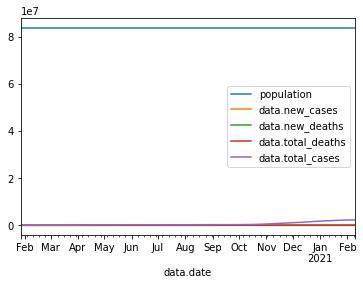

In [120]:
dt_germany.plot()

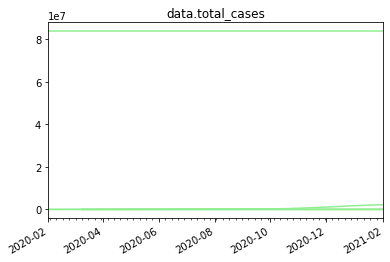

In [87]:
#Otra opcion de representarlo
import matplotlib.dates as mdates
for f in set(dt):
    ax = dt[f].plot(y=f, title=f, legend=False, xlabel='', color='lightgreen')
    ax.set_xlim(pd.Timestamp('2020-02-01'), pd.Timestamp('2021-02-01'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate()
#dt_germany["data.new_cases"].plot()

In [12]:
dt= dt_germany.drop(columns=["location", "population"])
dt

,data.new_cases,data.new_deaths,data.total_deaths,data.total_cases
data.date,,,,
2020-01-27,1.0,0.0,0.0,1.0
2020-01-28,3.0,0.0,0.0,4.0
2020-01-29,0.0,0.0,0.0,4.0
2020-01-30,0.0,0.0,0.0,4.0
2020-01-31,1.0,0.0,0.0,5.0
...,...,...,...,...
2021-02-06,8632.0,227.0,61551.0,2285003.0
2021-02-07,6670.0,157.0,61708.0,2291673.0
2021-02-08,4650.0,483.0,62191.0,2296323.0


<AxesSubplot:xlabel='data.date'>

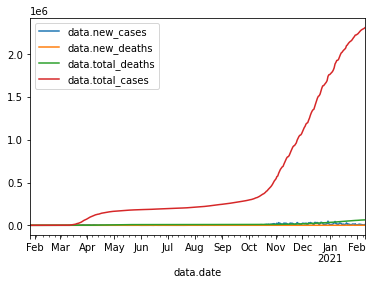

In [129]:
dt.plot()


3. Entrena los algoritmos de regresión que hemos visto hasta ahora para predecir dos columnas por separado: Nuevos casos y Nuevos fallecidos. Este modelo ha de entrenarse siguiendo el esquema recomendado de validación cruzada y almacenando los errores de entrenamiento y validación en cada iteración del entrenamiento. ¿Qué error se comete? ¿crees que los algoritmos de ML vistos hasta ahora son buenos para realizar un forecast de una serie temporal viendo los resultados?

4. Representa la evolución de los errores de validación y entrenamiento en una gráfica. ¿Ha habido sobreaprendizaje?. Utiliza n_iteraciones = 23 y batches = 7 para este ejercicio y solo para la columna "nuevos casos".

In [13]:
X=  dt.drop(columns= "data.new_cases").values
y = dt["data.new_cases"].values
X.shape, y.shape

((381, 3), (381,))

In [131]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [132]:
k_fold = RepeatedKFold(n_splits=23, n_repeats=7)

In [77]:
def cross_validation(model,dt, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)
    k_fold = RepeatedKFold(n_splits=23, n_repeats=7)
    error_train = []
    error_val = []
    
    for i, (train, val) in enumerate(k_fold.split(X_train)): #accedo a los trocitos del kfold
        if model == PolynomialFeatures():
            model = {"Polynomial":PolynomialFeatures(5),
                    "Linear":LinearRegression()}
        else:
            model = model
        
        model.fit(X_train[train], y_train[train])
        
        #error train
        train_error = model.score(X_train[train], y_train[train])
        error_train.append(train_error)

        #error val
        val_error = model.score(X_train[val], y_train[val])
        error_val.append(val_error)

        y_pred_train = model.predict(X_train)
    dict_dt = {"Error Train": error_train, "Error val": error_val}
    data = pd.DataFrame(dict_dt)
    print("Model:", model)
    return data, data.plot()
    


Model: LinearRegression()


(     Error Train  Error val
 0       0.739753   0.629250
 1       0.725549   0.804885
 2       0.741206   0.330892
 3       0.743499   0.215261
 4       0.744412   0.459465
 ..           ...        ...
 156     0.732792   0.852555
 157     0.735033   0.794978
 158     0.744149   0.545830
 159     0.740142   0.584560
 160     0.743360   0.517010
 
 [161 rows x 2 columns],
 <AxesSubplot:>)

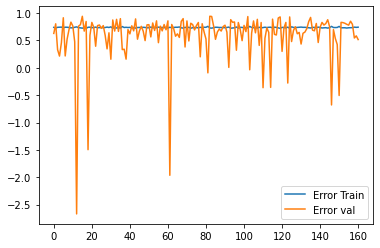

In [71]:
linear_reg= cross_validation(model=LinearRegression(),dt=dt, X=dt.drop(columns= "data.new_cases").values, y=dt["data.new_cases"].values)
linear_reg

Model: SVR()


(     Error Train  Error val
 0      -0.259936  -0.595314
 1      -0.270519  -0.293829
 2      -0.271861  -0.199695
 3      -0.257103  -0.643323
 4      -0.267282  -0.311218
 ..           ...        ...
 156    -0.256558  -0.722163
 157    -0.260171  -0.496017
 158    -0.270600  -0.475440
 159    -0.272436  -0.328401
 160    -0.270162  -0.277045
 
 [161 rows x 2 columns],
 <AxesSubplot:>)

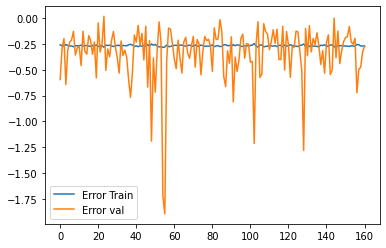

In [72]:
svr= cross_validation(model=SVR(),dt=dt, X=dt.drop(columns= "data.new_cases").values, y=dt["data.new_cases"].values)
svr

Model: RandomForestRegressor()


(     Error Train  Error val
 0       0.977114  -2.150348
 1       0.968848   0.605782
 2       0.968488   0.916203
 3       0.971467   0.710507
 4       0.968271   0.868619
 ..           ...        ...
 156     0.970642   0.804084
 157     0.964478   0.884495
 158     0.968286   0.763732
 159     0.968109   0.951453
 160     0.968963   0.833265
 
 [161 rows x 2 columns],
 <AxesSubplot:>)

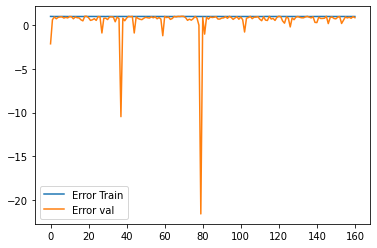

In [75]:
Rfr= cross_validation(model=RandomForestRegressor(),dt=dt, X=dt.drop(columns= "data.new_cases").values, y=dt["data.new_cases"].values)
Rfr

In [78]:
#Cambiar el score. 
poly= cross_validation(model=PolynomialFeatures(),dt=dt, X=dt.drop(columns= "data.new_cases").values, y=dt["data.new_cases"].values)
poly

AttributeError: 'PolynomialFeatures' object has no attribute 'score'

# Pruebas

<AxesSubplot:>

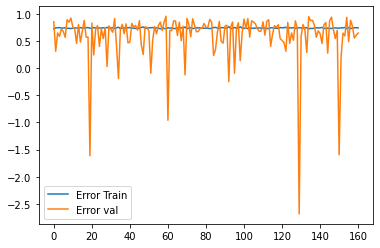

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)
k_fold = RepeatedKFold(n_splits=23, n_repeats=7)
error_train = []
error_val = []
dict_dt = {"Error Train": error_train, "Error val": error_val}
for i, (train, val) in enumerate(k_fold.split(X_train)): #accedo a los trocitos del kfold
    model = model
    model.fit(X_train[train], y_train[train])
    #print("Model:", model)
    #error train
    train_error = model.score(X_train[train], y_train[train])
    error_train.append(train_error)
    #print(error_train)
    #error val
    val_error = model.score(X_train[val], y_train[val])
    error_val.append(val_error)
    #print("error val", error_val)
    y_pred_train = model.predict(X_train)
dict_dt = {"Error Train": error_train, "Error val": error_val}
data = pd.DataFrame(dict_dt)
data.plot()  


In [67]:
#Porque con el MAE me aparece esto?
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)
k_fold = RepeatedKFold(n_splits=23, n_repeats=7)
error_train = []
error_val = []

for i, (train, val) in enumerate(k_fold.split(X_train)): #accedo a los trocitos del kfold
    model = LinearRegression()
    model.fit(X_train[train], y_train[train])
    #print("Model:", model)
    y_pred_train = model.predict(X_train)
    #error train
    train_error = y_train[train] - y_pred_train[train]
    error_train.append(train_error)
   
    #error val
    val_error = y_train[val] - y_pred_train[val]
    error_val.append(val_error)

dict_dt = {"Error Train": error_train, "Error val": error_val}
data = pd.DataFrame(dict_dt)
data

    

,Error Train,Error val
0,"[-231.05607747789054, 381.45674275229976, 5999...","[4763.354793521939, 646.4932311140901, 3999.32..."
1,"[-240.5944810012079, 368.823197897902, 5936.60...","[-373.0085823829695, 962.9199897440067, 1432.0..."
2,"[435.51933169353924, 5983.097670514053, 4695.1...","[-173.79385459745208, 760.9505354302919, 1146...."
3,"[-284.7441866938643, 316.0265905004035, 5650.0...","[1018.2076465549862, -10932.966921669531, 83.5..."
4,"[-249.98745108581534, 5682.143372429287, 4374....","[349.93615066944585, 370.3945498491703, 797.77..."
...,...,...
156,"[-306.5329750831479, 307.05941053660445, 6039....","[18955.00759274135, -1498.0657330976792, 996.4..."
157,"[-244.35398329955387, 370.1625731863278, 6059....","[165.77087577138172, 1444.1682362429437, 677.4..."
158,"[-286.9809231487234, 307.8836787518003, 5507.9...","[802.6177533176797, -556.8785208599684, 708.85..."
159,"[-245.20240265228495, 347.7767090158786, 5499....","[452.13444428855837, -1754.0012347067868, 137...."


In [137]:
len(data["Error Train"][0])

290

In [140]:
data


,Error Train,Error val
0,"[-250.6452504317058, 352.17242531059037, 5746....","[-3674.427167833161, 57.965929799011064, 3651...."
1,"[-250.6452504317058, 352.17242531059037, 5746....","[-5494.985302264438, 327.72505944138356, 512.3..."
2,"[-250.6452504317058, 352.17242531059037, 5746....","[1045.2618006319744, -3674.5082803589603, -367..."
3,"[-250.6452504317058, 352.17242531059037, 5746....","[4435.3085642605765, 11346.028739298996, 17831..."
4,"[-250.6452504317058, 352.17242531059037, 5746....","[3957.4259960532045, 741.2504627016478, 640.61..."
...,...,...
156,"[-250.6452504317058, 352.17242531059037, 5746....","[-3674.400130324562, -137.79503060594652, 641...."
157,"[-250.6452504317058, 352.17242531059037, 5746....","[-22.170800700127074, 643.865843923636, 710.72..."
158,"[-250.6452504317058, 352.17242531059037, 5746....","[1227.36094333226, 459.3023290920801, -3650.34..."
159,"[-250.6452504317058, 352.17242531059037, 5746....","[57.965929799011064, -5494.985302264438, -3213..."
